# Advanced Lane Detection

In [2]:
import os
import sys
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

root_dir = "/Users/xi/Documents/coding/udacity_self_driving/CarND-Advanced-Lane-Lines"
cam_cal_dir = os.path.join(root_dir, "camera_cal")
test_img_dir = os.path.join(root_dir, "test_images")
output_img_dir = os.path.join(root_dir, "output_images")

scale = 720/1280 # Scale the 1280 image down to 720 image
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

## Part I. Camera Calibration

In [3]:
objpoints = []
imgpoints = []

objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob(os.path.join(cam_cal_dir, "*.jpg"))
for idx, fname in enumerate(images):
    img = cv2.imread(os.path.join(cam_cal_dir, fname))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        # cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

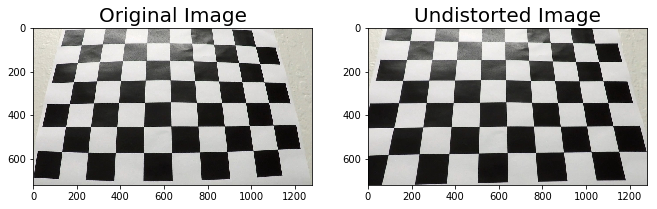

In [4]:
# Test undistortion
img = mpimg.imread(os.path.join(cam_cal_dir, 'calibration3.jpg'))
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)

## Part II. Color/gradient threshold

In [5]:
img = mpimg.imread(os.path.join(test_img_dir, 'test3.jpg'))
img = cv2.undistort(img, mtx, dist, None, mtx)

#### Absolute Sobel

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [7]:
grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 130))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded x Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

NameError: name 'image' is not defined

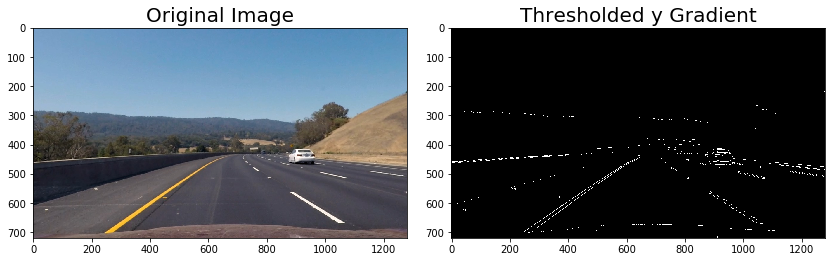

In [10]:
grad_binary = abs_sobel_thresh(img, orient='y',sobel_kernel=3, thresh=(70, 130))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded y Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Magnitude of Gradient

In [11]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


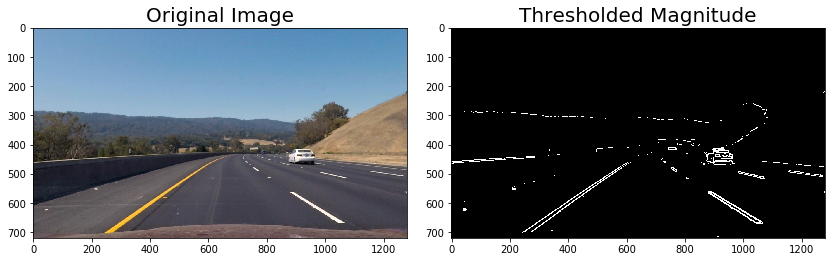

In [12]:
mag_binary = mag_thresh(img, sobel_kernel=15, mag_thresh=(80, 255))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Direction of Gradient

In [13]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgradient = np.arctan2(abs_sobely, abs_sobelx)

    binary_output = np.zeros_like(gray)
    binary_output[(absgradient >= thresh[0]) & (absgradient <= thresh[1])] = 1
    return binary_output

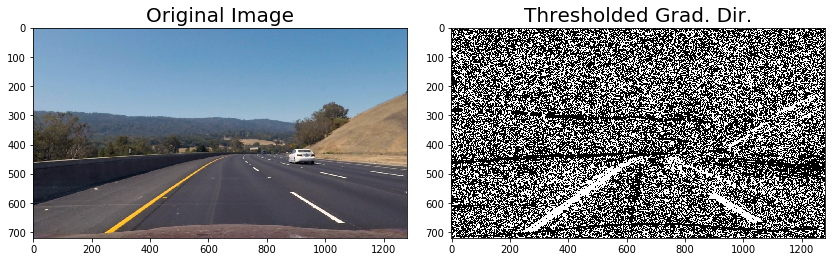

In [14]:
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
def hls_select(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

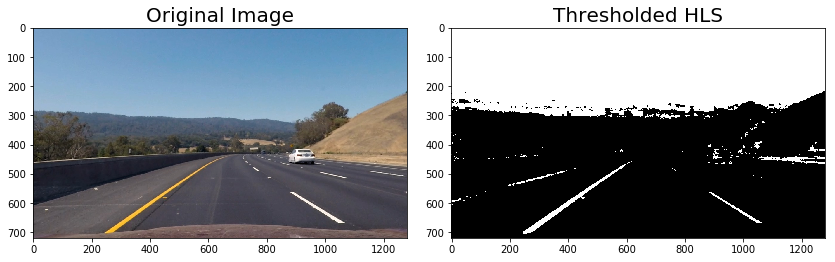

In [16]:
hls_binary = hls_select(img, thresh=(90, 255))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded HLS', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
def combine_thresh(image, debug=False):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(30, 230))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(30, 230))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(80, 150))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(image, thresh=(100, 150))
    if debug:
        f, axarr = plt.subplots(2, 3, figsize=(11, 5))
        f.tight_layout()
        axarr[0][0].imshow(image)
        axarr[0][0].set_title('Original Image', fontsize=20)
        axarr[0][1].imshow(gradx)
        axarr[0][1].set_title('Sobel X Threshold', fontsize=20)
        axarr[0][2].imshow(grady)
        axarr[0][2].set_title('Sobel Y Threshold', fontsize=20)
        axarr[1][0].imshow(mag_binary)
        axarr[1][0].set_title('Magnitude Threshold', fontsize=20)
        axarr[1][1].imshow(dir_binary)
        axarr[1][1].set_title('Direction Threshold', fontsize=20)
        axarr[1][2].imshow(hls_binary)
        axarr[1][2].set_title('HLS Threshold', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    return combined

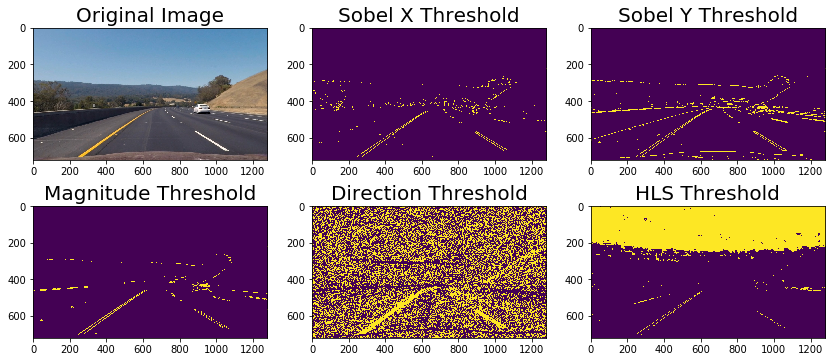

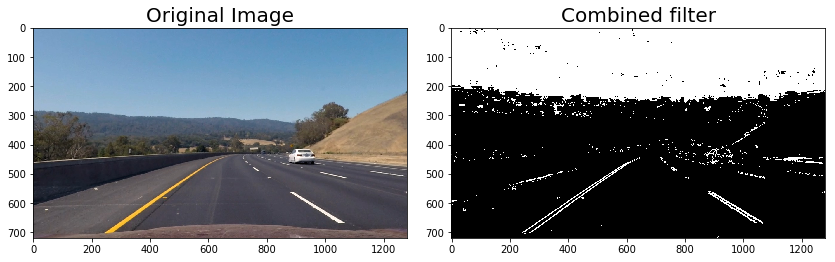

In [18]:
combined = combine_thresh(img, debug=True)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined filter', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Part III. Transform lane lines

In [19]:
def combine_thresh(image, debug=False):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(30, 230))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(30, 230))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(80, 150))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(image, thresh=(100, 150))
    if debug:
        f, axarr = plt.subplots(2, 3, figsize=(11, 5))
        f.tight_layout()
        axarr[0][0].imshow(image)
        axarr[0][0].set_title('Original Image', fontsize=20)
        axarr[0][1].imshow(gradx)
        axarr[0][1].set_title('Sobel X Threshold', fontsize=20)
        axarr[0][2].imshow(grady)
        axarr[0][2].set_title('Sobel Y Threshold', fontsize=20)
        axarr[1][0].imshow(mag_binary)
        axarr[1][0].set_title('Magnitude Threshold', fontsize=20)
        axarr[1][1].imshow(dir_binary)
        axarr[1][1].set_title('Direction Threshold', fontsize=20)
        axarr[1][2].imshow(hls_binary)
        axarr[1][2].set_title('HLS Threshold', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & ~(grady == 1)) | ((mag_binary == 1) & ~(dir_binary == 1)) | (hls_binary == 1)] = 1
    return combined

In [20]:
apex, apey = 630, 258
offset_far = 600
offset_near = 200
src = np.float32([[290, 675],
                  [576, 463],
                  [710, 463],
                  [1050, 675]])
dst = np.float32([[250, 719],
                  [250, 100],
                  [1050, 100],
                  [1050, 719]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warper(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(image, M, dsize=(image.shape[1],image.shape[0]), flags = cv2.INTER_LINEAR)
    return warped

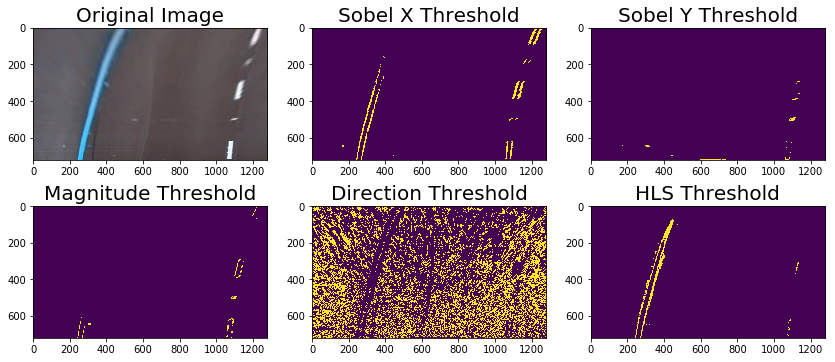

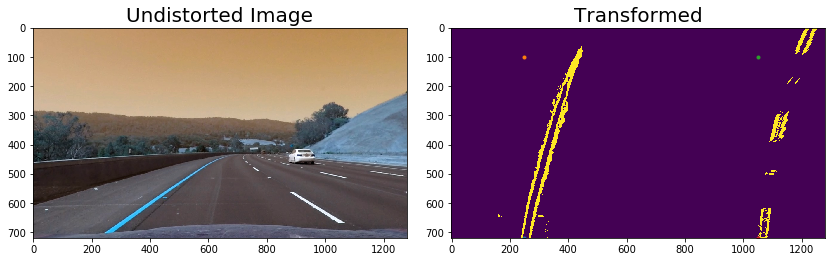

In [21]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = warper(img, src, dst)
binary_warped = combine_thresh(warped, debug=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(binary_warped)
plt.plot(dst[0][0], dst[0][1], '.')
plt.plot(dst[1][0], dst[1][1], '.')
plt.plot(dst[2][0], dst[2][1], '.')
plt.plot(dst[3][0], dst[3][1], '.')
ax2.set_title('Transformed', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Determine the lane curvature

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fit_line_init(binary_warped, nwindows = 9, debug=False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if debug:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit

In [23]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def fit_line(binary_warped, debug=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if debug:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit

### Measuring Curvature

In [59]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calc_curvature(yvals, fitx):
    y_eval = np.max(yvals)
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def calc_position(yvals, left_fitx, right_fitx, center):
    """
    Return the derivation of the car from the center of the lane.
    If the return value < 0, it means the car is on the left of the center
    If the return value > 0, it means the car is on the right of the center
    """
    y_index = np.argmax(yvals)
    left  = left_fitx[y_index]
    right = right_fitx[y_index]
    position = (left + right) / 2  
    return (center - position) * xm_per_pix

### Draw lane

In [60]:
# Create an image to draw the lines on
def draw_lane(image, binary_warped, left_fit, right_fit, Minv, debug=False):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_curvature = calc_curvature(ploty, left_fitx)
    right_curvature = calc_curvature(ploty, right_fitx)
    
    center = binary_warped.shape[1] // 2
    derivation = calc_position(ploty, left_fitx, right_fitx, center)
#     cv2.circle(image, (int(position//xm_per_pix), 700), 30, (0,255,0), -11)
#     cv2.circle(image, (int(center//xm_per_pix), 700), 30, (0,0,255), -11)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    text = "Curvature: {} m".format((left_curvature + right_curvature) // 2)
    cv2.putText(result, text,(100,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    if derivation < 0:
        text = "Vehicle is {:.2f} m left".format(-derivation)
    else:
        text = "Vehicle is {:.2f} m right".format(derivation)
    cv2.putText(result, text,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    return result

### Pipeline processing images

In [26]:
def process_image(image, debug=False):
    warped = warper(image, src, dst)
    binary_warped = combine_thresh(warped, debug=debug)
    left_fit, right_fit = fit_line_init(binary_warped, debug=debug)
    result = draw_lane(image, binary_warped, left_fit, right_fit, Minv, debug=debug)
    return result

700.828208035 640
-0.321520528187


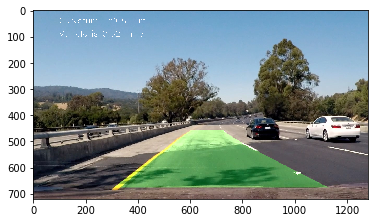

In [58]:
fname = "test%d.jpg" % 4
fname = os.path.join(test_img_dir, fname)
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
temp = process_image(img)
plt.figure()
plt.imshow(temp)

[  4.23840014e-04  -1.76598157e-01   1.07708672e+02] [ -2.66782378e-04   3.27832861e-01   1.08800553e+03]
3528.33059196 2103.68675398


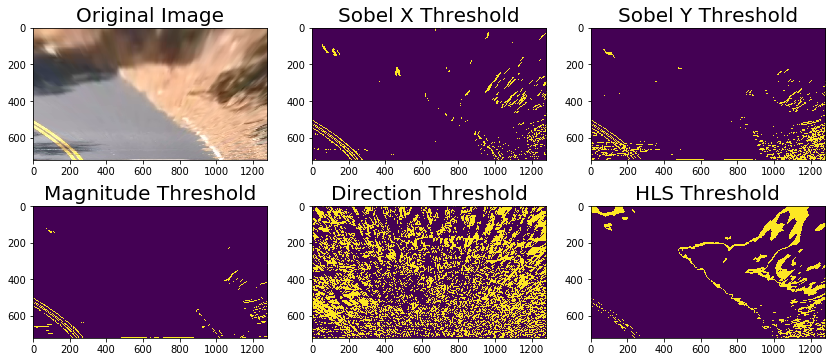

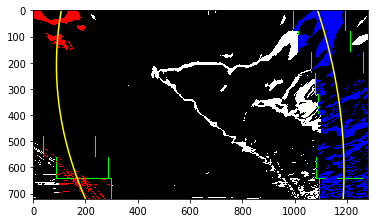

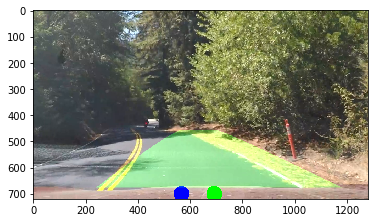

In [244]:
# Test how process_image works on single image

fname = "frame_%d.png" % i
fname = os.path.join(root_dir, fname)
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
temp = process_image(img, debug=True)
plt.figure()
plt.imshow(temp)

In [278]:
# Define a class to receive the characteristics of each line detection
class Line():
    history_num = 10
    def __init__(self, left_side=True):
        self.left_side = left_side
        self.cur_idx = 0
        self.detected = False  
        self.recent_xfitted = [None] * Line.history_num
        self.bestx = None     
        self.best_fit = None  
        self.current_fit = [np.array([False])]  
        self.diffs = np.array([0,0,0], dtype='float')
        
    def fit_line(self, binary_warped, debug=False):
        if self.detected:
            self._fit_line_cont(binary_warped)
            self.diffs = self.current_fit - self.best_fit
            if not self._sanity_check():
                self.detected = False
                self._fit_line_init(binary_warped)
        else:
            self._fit_line_init(binary_warped)
            
        self.recent_xfitted[self.cur_idx % Line.history_num] = self.current_fit
        self.cur_idx += 1
        self.best_fit = np.mean(self.recent_xfitted[:min(self.cur_idx, Line.history_num)], axis=0)
        return self.best_fit
    
    def _sanity_check(self):
        if np.mean(np.divide(self.diffs, self.current_fit)) > 0.2:
            return False
        return True
    
    def _fit_line_init(self, binary_warped, nwindows = 9):
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        midpoint = np.int(histogram.shape[0]/2)
        if self.left_side:
            base = np.argmax(histogram[:midpoint])
        else:
            base = np.argmax(histogram[midpoint:]) + midpoint
        window_height = np.int(binary_warped.shape[0]/nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        current = base
        margin = 100
        minpix = 50
        left_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = current - margin
            win_xleft_high = current + margin
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            if len(good_left_inds) > minpix:
                current = np.int(np.mean(nonzerox[good_left_inds]))

        lane_inds = np.concatenate(left_lane_inds)

        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        self.current_fit = np.polyfit(y, x, 2)
        self.detected = True
    
    def _fit_line_cont(self, binary_warped, debug=False):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] - margin)) & \
                          (nonzerox < (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + self.best_fit[2] + margin))) 
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 

        self.current_fit = np.polyfit(lefty, leftx, 2)

In [61]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4', audio=False)
new_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:49<00:00,  4.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 9s, sys: 1min 5s, total: 6min 15s
Wall time: 4min 50s


In [249]:
i = 0
clip1.save_frame("frame_%d.png" % i, t=i)